# Feature Engineering & Model Training

In [2]:
import pandas as pd
import shap
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Load cleaned dataset
df = pd.read_csv("../data/cleaned_loan_prediction.csv")

X = df.drop(["Loan_ID", "Loan_Status"], axis=1)
y = df["Loan_Status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try multiple models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    print(f"\n\033[1m{name} Results:\033[0m")
    print(classification_report(y_test, preds, digits=3))

# Hyperparameter Tuning for Random Forest
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 5, 10],
    "min_samples_split": [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring="f1")
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print("\n\033[1mBest Random Forest Model from GridSearchCV:\033[0m")
print(grid_search.best_params_)

best_preds = best_model.predict(X_test_scaled)
print("\n\033[1mRandom Forest with Best Params Results:\033[0m")
print(classification_report(y_test, best_preds, digits=3))

/Users/hussam/Desktop/dev-learning/mlt-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/hussam/Desktop/dev-learning/mlt-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hussam/Desktop/dev-learning/mlt-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hussam/Desktop/dev-learning/mlt-project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/hussam/Desktop/dev-learning/mlt-project/.venv/lib/pyt


Logistic Regression Results:
              precision    recall  f1-score   support

           0      0.947     0.419     0.581        43
           1      0.760     0.988     0.859        80

    accuracy                          0.789       123
   macro avg      0.853     0.703     0.720       123
weighted avg      0.825     0.789     0.761       123


Decision Tree Results:
              precision    recall  f1-score   support

           0      0.575     0.535     0.554        43
           1      0.759     0.787     0.773        80

    accuracy                          0.699       123
   macro avg      0.667     0.661     0.664       123
weighted avg      0.695     0.699     0.697       123


Random Forest Results:
              precision    recall  f1-score   support

           0      0.857     0.419     0.562        43
           1      0.755     0.963     0.846        80

    accuracy                          0.772       123
   macro avg      0.806     0.691     0.704       

## Feature Importances

/var/folders/4t/xsjp3gpx3b34h757myxc0qlm0000gn/T/ipykernel_92824/3696479410.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="viridis")


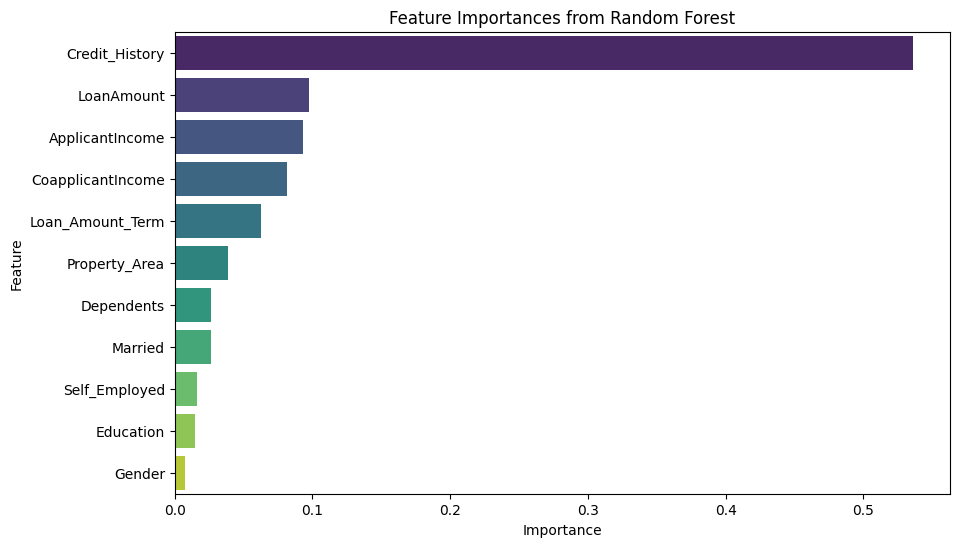

In [3]:
importances = best_model.feature_importances_
feat_names = X.columns
feat_imp_df = pd.DataFrame({"Feature": feat_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df, palette="viridis")
plt.title("Feature Importances from Random Forest")
plt.show()

# SHAP Explanation (global & local)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train_scaled)

# Save the model

In [4]:
# Save the best trained model
joblib.dump(best_model, "../model/loan_approval_model.pkl")

# Save the fitted scaler
joblib.dump(scaler, "../model/scaler.pkl")

# Save the feature column order
joblib.dump(X.columns.tolist(), "../model/model_features.pkl")

print("✅ Model, scaler, and feature list saved successfully.")

✅ Model, scaler, and feature list saved successfully.


# Load the model

In [5]:
# Load saved components
model = joblib.load("../model/loan_approval_model.pkl")
scaler = joblib.load("../model/scaler.pkl")
feature_columns = joblib.load("../model/model_features.pkl")

# Saving Model Metrics

In [7]:
import json
model_metrics = {
    "accuracy": float(accuracy_score(y_test, best_preds)),
    "precision": float(precision_score(y_test, best_preds, average="weighted")),
    "recall": float(recall_score(y_test, best_preds, average="weighted")),
    "f1_score": float(f1_score(y_test, best_preds, average="weighted"))
}
with open("../static/data/model_metrics.json", "w") as f:
    json.dump(model_metrics, f, indent=4)